# Implementing $\pi_{\rm int} + \pi_{\rm OU}$ on the semi-circle
Simulation of agent following pheromone along a semi-circle connecting points A and B for a given distance/angle followed by exploration under OU policy. The agent lays pheromone on the way back if it succeeds in reaching Point B.
## TOC:
* [Agent following part intrinsic-policy and part OU-policy with reward](#first-bullet)
* [Epsilon-greedy policy](#second-bullet)

In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy

import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node
import time
import matplotlib.patheffects as path_effects

import importlib
import plotFns as pF
import prmts as pR


In [2]:
global colors
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

 ## <a class="anchor" id="first-bullet">Agent following part intrinsic-policy and part OU-policy with reward</a>

Dynamics of an agent following $\pi_{\rm int}$ for a distance and shifting to $\pi_{\rm OU}$ towards the target

In [3]:
# Parameters in the model
class params():
    def __init__(self) -> None:
        super().__init__()
        self.nSteps = 600 #number of steps of each run
        self.nEpchs = 250 #number of epochs
        self.a = 1.0 #radius of semi-circle
        self.nIntSteps = int(0.5*self.nSteps) #number of steps of intrinsic policy
        
        # Pheromone parameters
        self.nMsh = 500 #number of points in 
        self.kM = 1 #rate of pheromone decay
        self.kP = 0.1 #rate of pheromone generation
        
        # Agent dynamics parameters
        self.pt = 0.05 #initial pheromone trail thickness
        self.sz = 0.02 #agent size (radius)
        self.dt = 1e-2 #time-step size
        self.l = 5e-3 #length travelled in 1 time-step
        self.vo = self.l/self.dt #effective speed of motion
        self.nu = 50 #orientation relaxation rate (s^-1)
        # self.diff = 50e-1 #noise diffusion coefficient (s^-1)
        self.diff = 10/(self.nIntSteps*self.l) #noise diffusion coefficient (s^-1)
        self.pe = self.diff/self.nu #peclet number
        
        # Reward parameters
        self.phiSt = np.pi/8 #reward goes as exp(-\phi/\phiSt)
        self.sigma = 0.1 #radius of region near target within which agent succeeds
        
        # Initial conditions
        self.rInit = np.array([self.a + np.random.uniform(-self.pt, self.pt), 0.0]) #initial location of agent
        self.tgt = np.array([-self.a, 0.0]) #target location of agent
        self.thetInit = 0.5*np.pi #initial orientation of agent
        # self.rng = random.PRNGKey(1) #initial random number
        self.tgtPhi = 0.0 #target orientation from current location

# Pheromone initial condition and class
p = params()
xvec = np.linspace(-1.5*p.a, 1.5*p.a, p.nMsh)
xphm, yphm = np.meshgrid(xvec,
                         xvec)
cInit = np.zeros((p.nMsh, p.nMsh))
for ix in range(p.nMsh):
    for iy in range(p.nMsh):
        r = np.sqrt(xphm[ix][iy]**2+yphm[ix][iy]**2)
        if (r > (p.a-p.pt))  & (r < (p.a+p.pt)) & (yphm[ix][iy] >= 0):
            cInit[ix][iy] = 1.0
class phrmn():
    def __init__(self, cInit):
        super().__init__()
        self.c = cInit
        
# Interpolate value of pheromone to location r 
def phmChk(r, c):
    cVal = sp.interpolate.interp2d(xvec, xvec, c, kind='cubic')
    return cVal(r[0], r[1])

In [4]:
phm = phrmn(cInit)
# Agent class
class agent():
    global phm
    def __init__(self, ptr):
        super().__init__()
        p = copy.deepcopy(ptr)
        self.r = p.rInit
        self.thet = p.thetInit
        self.rwd = 0.0
        self.sTrl = 0.0
        self.sInd = 0
        
    def intPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        phi = np.arctan2(self.r[1], self.r[0])
        self.thet = phi + 0.5*np.pi + np.random.uniform(-np.pi/5, np.pi/5)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.rwd += np.exp(-phi/p.phiSt)*p.l
        
        # cVal = phmChk(self.r, phm)
        # if ((1.0-cVal) < 1e-3):
        if np.linalg.norm(self.r) > (p.a+p.pt):
            self.thet = self.thet + np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
            
        if np.linalg.norm(self.r) < (p.a-p.pt):
            self.thet = self.thet - np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
    
    def ouPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.thet = self.thet*(1-p.nu*p.dt) + p.nu*p.dt*p.tgtPhi + np.sqrt(2*p.diff*p.dt)*np.random.normal()
        if np.linalg.norm(self.r - p.tgt) < p.sigma:
            self.rwd += np.pi*p.a - self.sTrl
            self.sInd = p.nSteps
        # self.thet = self.thet*(1-p.l) + p.l*p.tgtPhi + np.sqrt(2*p.pe*p.l)*np.random.normal()


In [30]:
p = params()
ag = agent(p)
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
# thetFull = np.array(p.thetInit)
phxFull = np.array(np.cos(p.thetInit))
phyFull = np.array(np.sin(p.thetInit))
rwdFull = np.array(0.0)
for ind in range(p.nSteps):
    if ind < p.nIntSteps:
        ag.intPolicy(p)
    elif ind == p.nIntSteps:
        tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r) #Orientation of the target from given location
        p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
        ag.ouPolicy(p)
    else:
        ag.ouPolicy(p)
    ag.sTrl += p.l
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
    phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
    rwdFull = np.vstack((rwdFull, np.array(ag.rwd)))
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.05186724662780762 seconds ---


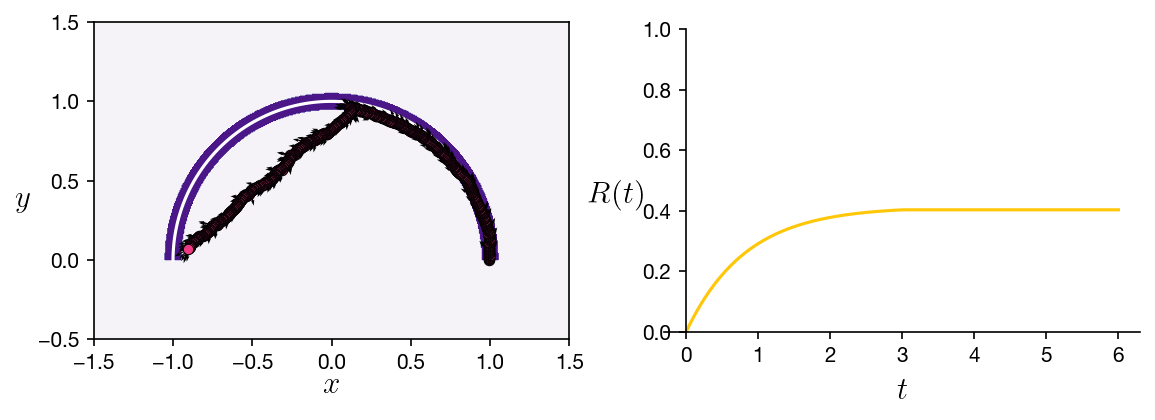

In [49]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")
linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#EE3984'
lcolor = '#FFC708'

fig, ax = plt.subplots(1,2,figsize=(9,9), gridspec_kw={'width_ratios': [1, 1]}, dpi=150)
ax[0].contourf(xphm, yphm, phm.c, cmap='Purples')
thetPlt = np.linspace(0., np.pi, 200)
ax[0].plot(p.a*np.cos(thetPlt), p.a*np.sin(thetPlt), c='white', zorder=1)

ax[0].scatter(rxFull, ryFull,
        s=25,
        color=color,
        edgecolors='k',
        linewidth=0.5,
        alpha=1,
        zorder=2)
ax[0].quiver(rxFull, ryFull,
        phxFull, phyFull,
        scale_units='xy',
        color='k',
        scale=10.2)
ax[0].set_xlabel(r'$x$',usetex=True, fontsize=label_size)
ax[0].set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)
ax[0].xaxis.set_label_coords(0.5,-0.1)
ax[0].yaxis.set_label_coords(-0.15,0.4)
ax[0].set_aspect(1)
ax[0].set_ylim([-0.5,1.5])

t = np.arange(np.size(rwdFull))*p.dt
ax[1].plot(t, rwdFull, color = lcolor)
ax[1].set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax[1].set_ylabel(r'$R(t)$',usetex=True,rotation=0, fontsize=label_size)
ax[1].set_ylim([0.,1.0])

ax[1].xaxis.set_label_coords(0.5,-0.15)
ax[1].yaxis.set_label_coords(-0.1,0.4)

ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["left"].set_position(("data", 0))
ax[1].spines["bottom"].set_position(("data", 0))
ax[1].set_aspect(np.max(t)*0.7)
plt.show()

In [89]:
def plotVidFn(p, rxFull, ryFull, phxFull, phyFull):
        mpl.rcParams.update(mpl.rcParamsDefault)
        plt.rc("font", family="Helvetica Neue")
        plt.rc("xtick", labelsize="medium")
        linewidth = 1.2
        linestyle = "-"
        label_size = 15
        color = '#EE3984'
        lcolor = '#FFC708'
        acolor = '#7A7A7A'

        t = np.arange(np.size(rwdFull))*p.dt
        fInd = 0
        for ind in np.arange(0,np.size(rxFull),10):
        # for ind in range(10):
                fig, ax = plt.subplots(1,2,figsize=(9,9), gridspec_kw={'width_ratios': [1, 1]}, dpi=150)
                ax[0].contourf(xphm, yphm, phm.c, cmap='Purples')
                thetPlt = np.linspace(0., np.pi, 200)
                ax[0].plot(p.a*np.cos(thetPlt), p.a*np.sin(thetPlt), c='white', zorder=1)
                ax[0].scatter(rxFull[ind], ryFull[ind],
                        s=30,
                        color=color,
                        edgecolors='k',
                        linewidth=0.5,
                        alpha=1,
                        zorder=2)
                ax[0].quiver(rxFull[ind], ryFull[ind],
                        phxFull[ind], phyFull[ind],
                        scale_units='xy',
                        color=acolor,
                        scale=10.2)
                ax[0].set_xlabel(r'$x$',usetex=True, fontsize=label_size)
                ax[0].set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)
                ax[0].xaxis.set_label_coords(0.5,-0.05)
                ax[0].yaxis.set_label_coords(-0.1,0.5)
                ax[0].set_aspect(1)
                ax[0].set_ylim([-0.5,1.5])
                ax[0].set_xticks([])
                ax[0].set_yticks([])

                
                ax[1].plot(t[0:ind], rwdFull[0:ind], color = lcolor)
                ax[1].plot(t[ind], rwdFull[ind], 'o', color = lcolor)
                
                ax[1].set_xlabel(r'$t$',usetex=True, fontsize=label_size)
                ax[1].set_ylabel(r'$R(t)$',usetex=True,rotation=0, fontsize=label_size)
                ax[1].set_ylim([0., 1.0])
                ax[1].set_xlim([0., np.max(t)])

                ax[1].xaxis.set_label_coords(0.5,-0.15)
                ax[1].yaxis.set_label_coords(-0.15,0.5)

                ax[1].spines["right"].set_visible(False)
                ax[1].spines["top"].set_visible(False)
                ax[1].spines["left"].set_position(("data", 0))
                ax[1].spines["bottom"].set_position(("data", 0))
                ax[1].set_aspect(np.max(t)*0.7)
                plt.tight_layout()
                plt.savefig("Inter"+str(fInd)+".png")
                plt.close()
                fInd += 1
        return

In [91]:
! rm *.png

In [90]:
plotVidFn(p, rxFull, ryFull, phxFull, phyFull)
! ffmpeg -r 10 -i "Inter%d.png" -c:v libx264 -vf fps=10 -pix_fmt yuv420p ./Check.mp4
#! rm *.png

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack

Single trajectory check

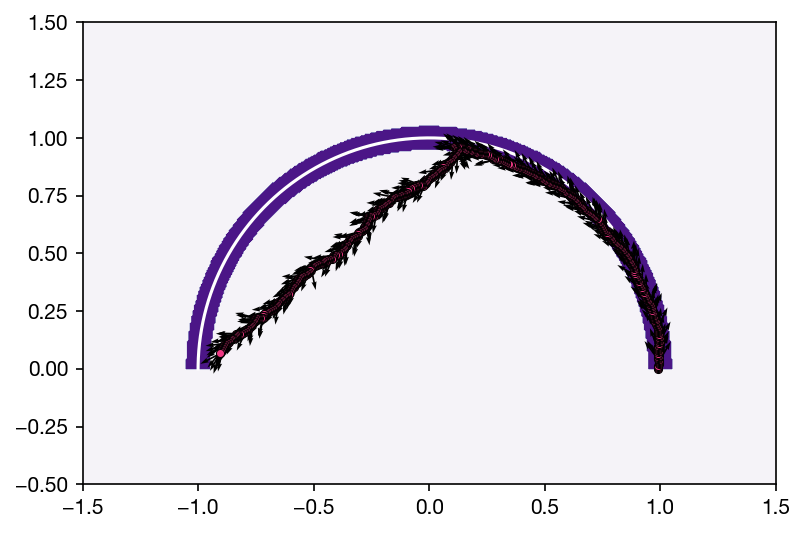

In [48]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")
linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#EE3984'

fig = plt.figure(figsize=(8, 4), dpi=150)
ax = plt.subplot(1, 1, 1, aspect=1)
ax.contourf(xphm, yphm, phm.c, cmap='Purples')
thetPlt = np.linspace(0., np.pi, 200)
ax.plot(p.a*np.cos(thetPlt), p.a*np.sin(thetPlt), c='white', zorder=1)

ax.scatter(rxFull, ryFull,
            s=15,
            color=color,
            edgecolors='k',
            linewidth=0.5,
            alpha=1,
            zorder=2)
ax.quiver(rxFull, ryFull,
           phxFull, phyFull,
           scale_units='xy',
           color='k',
           scale=10.2)
ax.set_ylim([-0.5,1.5])
ax.set_aspect(1)
plt.show()

--- 9.324658870697021 seconds ---


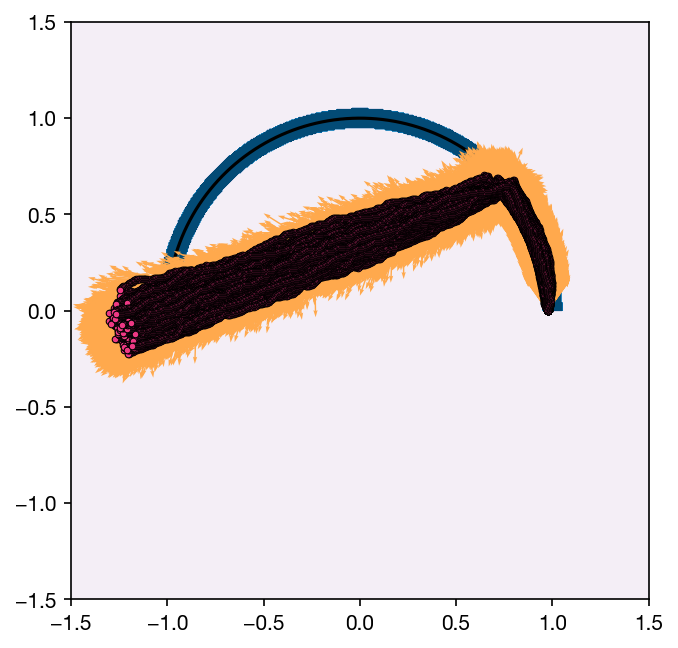

In [100]:
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
phxFull = np.array(np.cos(p.thetInit))
phyFull = np.array(np.sin(p.thetInit))

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")
linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#EE3984'
fig = plt.figure(figsize=(5, 5), dpi=150)
ax = plt.subplot(1, 1, 1, aspect=1) 
ax.contourf(xphm, yphm, phm.c, cmap='PuBu')
thetPlt = np.linspace(0., np.pi, 200)
ax.plot(p.a*np.cos(thetPlt), p.a*np.sin(thetPlt), c='k', zorder=1)

for eInd in range(p.nEpchs):
    ag = agent(p)
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    phxFull = np.array(np.cos(p.thetInit))
    phyFull = np.array(np.sin(p.thetInit))
    # for ind in range(p.nSteps):
    while ag.sInd <= p.nSteps:
        if ind < p.nIntSteps:
            ag.intPolicy(p)
        elif ind == p.nIntSteps:
            tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r) #Orientation of the target from given location
            p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
            ag.ouPolicy(p)
        else:
            ag.ouPolicy(p)
        rxFull = np.vstack((rxFull, np.array(ag.r[0])))
        ryFull = np.vstack((ryFull, np.array(ag.r[1])))
        phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
        phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
        ag.sInd += 1
    
    ax.scatter(rxFull, ryFull,
                s=10,
                color=color,
                edgecolors='k',
                linewidth=0.5,
                zorder=2)
    ax.quiver(rxFull, ryFull,
            phxFull, phyFull,
            scale_units='xy',
            color=colors['orange'][4],
            scale=5.2)

    ax.set_aspect(1)
print("--- %s seconds ---" % (time.time() - start_time))
plt.show()

--- 10.622045040130615 seconds ---


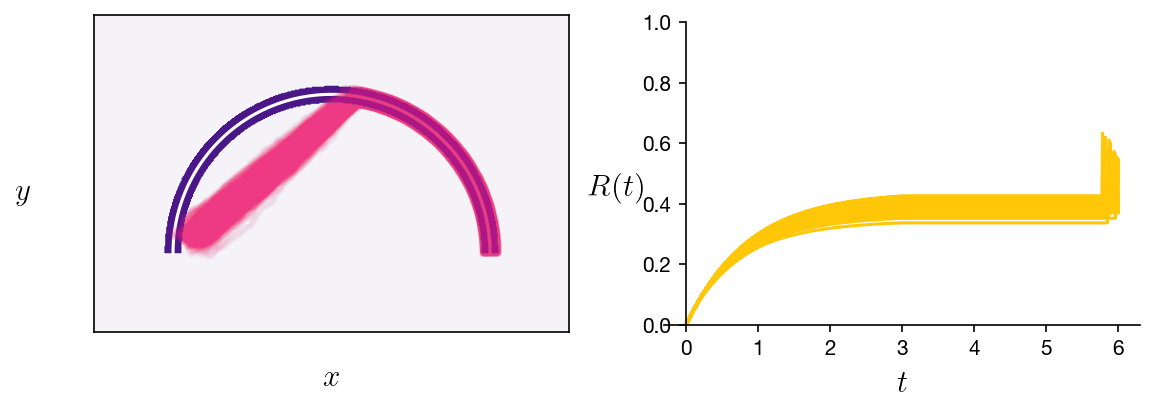

In [97]:
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
# thetFull = np.array(p.thetInit)
phxFull = np.array(np.cos(p.thetInit))
phyFull = np.array(np.sin(p.thetInit))
rwdFull = np.array(0.0)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")
linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#EE3984'
lcolor = '#FFC708'

# fig = plt.figure(figsize=(10, 5), dpi=150)
# ax1 = plt.subplot(1, 2, 1, aspect=1)
# ax2 = plt.subplot(1, 2, 2)

fig, ax = plt.subplots(1,2,figsize=(9,9), gridspec_kw={'width_ratios': [1, 1]}, dpi=150)
ax[0].contourf(xphm, yphm, phm.c, cmap='Purples')
thetPlt = np.linspace(0., np.pi, 200)
ax[0].plot(p.a*np.cos(thetPlt), p.a*np.sin(thetPlt), c='white', zorder=1)


for eInd in range(p.nEpchs):
# for eInd in range(20):
    p = params()
    ag = agent(p)
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    phxFull = np.array(np.cos(p.thetInit))
    phyFull = np.array(np.sin(p.thetInit))
    rwdFull = np.array(0.0)
    while ag.sInd <= p.nSteps:
    # for ind in range(p.nSteps):
        if ag.sInd < p.nIntSteps:
            ag.intPolicy(p)
        elif ag.sInd == p.nIntSteps:
            tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r) #Orientation of the target from given location
            p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
            ag.ouPolicy(p)
        else:
            ag.ouPolicy(p)
        ag.sTrl += p.l
        ag.sInd += 1
        rxFull = np.vstack((rxFull, np.array(ag.r[0])))
        ryFull = np.vstack((ryFull, np.array(ag.r[1])))
        phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
        phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
        rwdFull = np.vstack((rwdFull, np.array(ag.rwd)))
        
    ax[0].scatter(rxFull, ryFull,
                s=10,
                color=color,
                edgecolors='k',
                linewidth=0.01,
                alpha=10/p.nSteps)
    # ax[0].quiver(rxFull, ryFull,
    #         phxFull, phyFull,
    #         scale_units='xy',
    #         color=colors['orange'][4],
    #         scale=5.2)
    ax[0].set_xlabel(r'$x$',usetex=True, fontsize=label_size)
    ax[0].set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)
    ax[0].xaxis.set_label_coords(0.5,-0.1)
    ax[0].yaxis.set_label_coords(-0.15,0.4)
    ax[0].set_aspect(1)
    ax[0].set_ylim([-0.5,1.5])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    t = np.arange(np.size(rwdFull))*p.dt
    # ax[1].plot(t, rwdFull, color = lcolor)
    # ax[1].set_xlabel(r'$t$',usetex=True, fontsize=label_size)
    # ax[1].set_ylabel(r'$R(t)$',usetex=True,rotation=0, fontsize=label_size)
    # ax[1].set_ylim([0.,1.0])

    # ax[1].xaxis.set_label_coords(0.5,-0.15)
    # ax[1].yaxis.set_label_coords(-0.1,0.4)

    # ax[1].spines["right"].set_visible(False)
    # ax[1].spines["top"].set_visible(False)
    # ax[1].spines["left"].set_position(("data", 0))
    # ax[1].spines["bottom"].set_position(("data", 0))
    # ax[1].set_aspect(np.max(t)/2)
    
    ax[1].plot(t, rwdFull, color = lcolor)
    ax[1].set_xlabel(r'$t$',usetex=True, fontsize=label_size)
    ax[1].set_ylabel(r'$R(t)$',usetex=True,rotation=0, fontsize=label_size)
    ax[1].set_ylim([0.,1.0])

    ax[1].xaxis.set_label_coords(0.5,-0.15)
    ax[1].yaxis.set_label_coords(-0.1,0.4)

    ax[1].spines["right"].set_visible(False)
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["left"].set_position(("data", 0))
    ax[1].spines["bottom"].set_position(("data", 0))
    ax[1].set_aspect(np.max(t)*0.7)
print("--- %s seconds ---" % (time.time() - start_time))
# plt.tight_layout()
plt.show()

 ## <a class="anchor" id="second-bullet">Epsilon-greedy policy</a>
 Agent updates its estimate of value function using $\epsilon$-greedy strategy

In [14]:
# Pheromone initial condition and class
p = pR.params()
xvec = np.linspace(-1.5*p.a, 1.5*p.a, p.nMsh)
xphm, yphm = np.meshgrid(xvec,
                         xvec)
cInit = np.zeros((p.nMsh, p.nMsh))
for ix in range(p.nMsh):
    for iy in range(p.nMsh):
        r = np.sqrt(xphm[ix][iy]**2+yphm[ix][iy]**2)
        if (r > (p.a-p.pt))  & (r < (p.a+p.pt)) & (yphm[ix][iy] >= 0):
            cInit[ix][iy] = 1.0
class phrmn():
    def __init__(self, cInit):
        super().__init__()
        self.c = cInit
        
# Interpolate value of pheromone to location r 
def phmChk(r, c):
    cVal = sp.interpolate.interp2d(xvec, xvec, c, kind='cubic')
    return cVal(r[0], r[1])
phm = phrmn(cInit)

In [32]:
# Agent class
class agent():
    global phm
    def __init__(self, ptr):
        super().__init__()
        p = copy.deepcopy(ptr)
        self.r = p.rInit #position of agent
        self.thet = p.thetInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent
        self.valFn = np.zeros(p.nPtn) #value function initialized to zero
        self.phiSc = 0. #Angle at which bifurcation happens
        
    def intPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        phi = np.arctan2(self.r[1], self.r[0])
        self.thet = phi + 0.5*np.pi + np.random.uniform(-np.pi/5, np.pi/5)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.rwd += np.exp(-phi/p.phiSt)*p.l
        
        if np.linalg.norm(self.r) > (p.a+p.pt):
            self.thet = self.thet + np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
            
        if np.linalg.norm(self.r) < (p.a-p.pt):
            self.thet = self.thet - np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
    
    def ouPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.thet = self.thet*(1-p.nu*p.dt) + p.nu*p.dt*p.tgtPhi + np.sqrt(2*p.diff*p.dt)*np.random.normal()
        if np.linalg.norm(self.r - p.tgt) < p.sigma:
            self.rwd += (np.pi - np.arctan2(self.r[1], self.r[0]))*p.a
            self.sInd = p.nSteps
        # self.valFn[iVal[0][-1]] = (self.valFn[iVal[0][-1]]+self.rwd)*0.5
        # self.thet = self.thet*(1-p.l) + p.l*p.tgtPhi + np.sqrt(2*p.pe*p.l)*np.random.normal()
    
    def reset(self, ptr):
        p = copy.deepcopy(ptr)
        self.r = p.rInit #position of agent
        self.thet = p.thetInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent

In [33]:
# Simple run
p = pR.params()
ag = agent(p)
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
# thetFull = np.array(p.thetInit)
phxFull = np.array(np.cos(p.thetInit))
phyFull = np.array(np.sin(p.thetInit))
rwdFull = np.array(0.0)
while ag.sInd <= p.nSteps:
    if ag.sInd < p.nSc:
        ag.intPolicy(p)
    elif ag.sInd == p.nSc:
        tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r) #Orientation of the target from given location
        p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
        p.diff = p.diffCst/(np.pi - np.arctan2(ag.r[1],ag.r[0]))
        ag.ouPolicy(p)
    else:
        ag.ouPolicy(p)
    ag.sTrl += p.l
    ag.sInd += 1
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
    phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
    rwdFull = np.vstack((rwdFull, np.array(ag.rwd)))
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0644838809967041 seconds ---


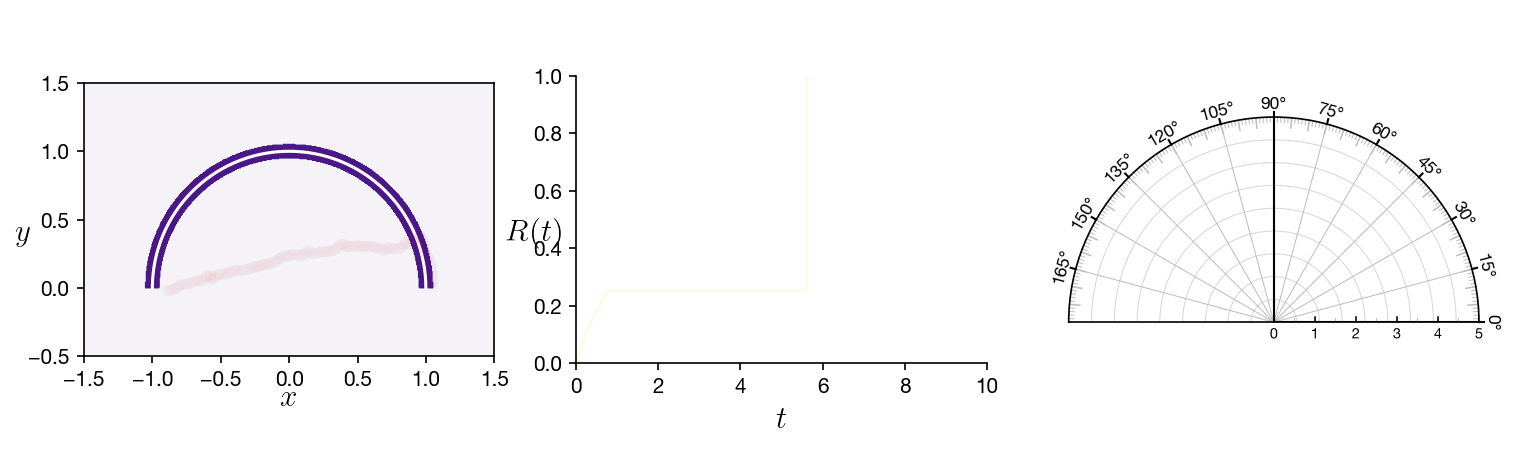

In [34]:
import importlib
importlib.reload(pF)
fix, ax = pF.plotDef(5, p, xphm, yphm, phm)
pF.plotDat(fix, ax, p, rxFull, ryFull, phxFull, phyFull, rwdFull, ag.valFn)
plt.show()

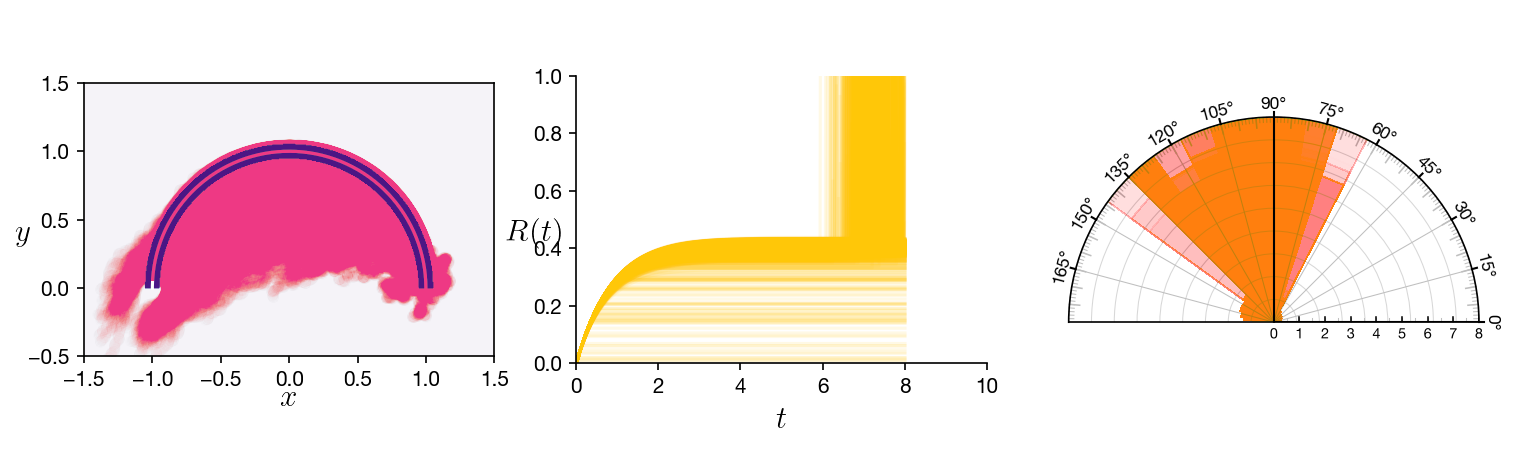

--- 117.02157592773438 seconds ---


In [44]:
importlib.reload(pF)
importlib.reload(pR)

phiPtn = np.linspace(0, np.pi, p.nPtn+1)
fix, ax = pF.plotDef(8, p, xphm, yphm, phm)

start_time = time.time()
ag = agent(p)

# for eInd in range(200):
for eInd in range(p.nEpchs):
    p = pR.params()
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    phxFull = np.array(np.cos(p.thetInit))
    phyFull = np.array(np.sin(p.thetInit))
    rwdFull = np.array(0.0)
    if (np.random.uniform() < p.epsilon) or (eInd < 100):
        p.nSc = np.random.uniform(0,np.pi)*(p.a-p.pt)//p.l
    else:
        iVmax = np.argmax(ag.valFn)
        p.nSc =  phiPtn[iVmax]//p.l
    # print(p.nSc)
    while ag.sInd <= p.nSteps:
        if ag.sInd < p.nSc:
            ag.intPolicy(p)
        elif ag.sInd == p.nSc:
            #Orientation of the target from given location
            tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r)
            p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
            #Diffusion as a function of \phi_c or equivalently s_c
            ag.phiSc = np.arctan2(ag.r[1], ag.r[0])
            # p.diff = p.diffCst/(np.pi - np.arctan2(ag.r[1],ag.r[0]))
            p.diff = p.diffCst/np.arctan2(ag.r[1],ag.r[0])
            ag.ouPolicy(p)
        else:
            ag.ouPolicy(p)
        ag.sTrl += p.l
        ag.sInd += 1
        rxFull = np.vstack((rxFull, np.array(ag.r[0])))
        ryFull = np.vstack((ryFull, np.array(ag.r[1])))
        phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
        phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
        rwdFull = np.vstack((rwdFull, np.array(ag.rwd)))
    iVal = np.where(phiPtn <= ag.phiSc)

    # ag.valFn[iVal[0][-1]] = (ag.valFn[iVal[0][-1]] + ag.rwd)*0.5
    ag.valFn[iVal[0][-1]] = ag.valFn[iVal[0][-1]]*(1 - p.alpha) + ag.rwd*p.alpha
    ag.reset(p)
    pF.plotDat(fix, ax, p, rxFull, ryFull, phxFull, phyFull, rwdFull, ag.valFn)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))


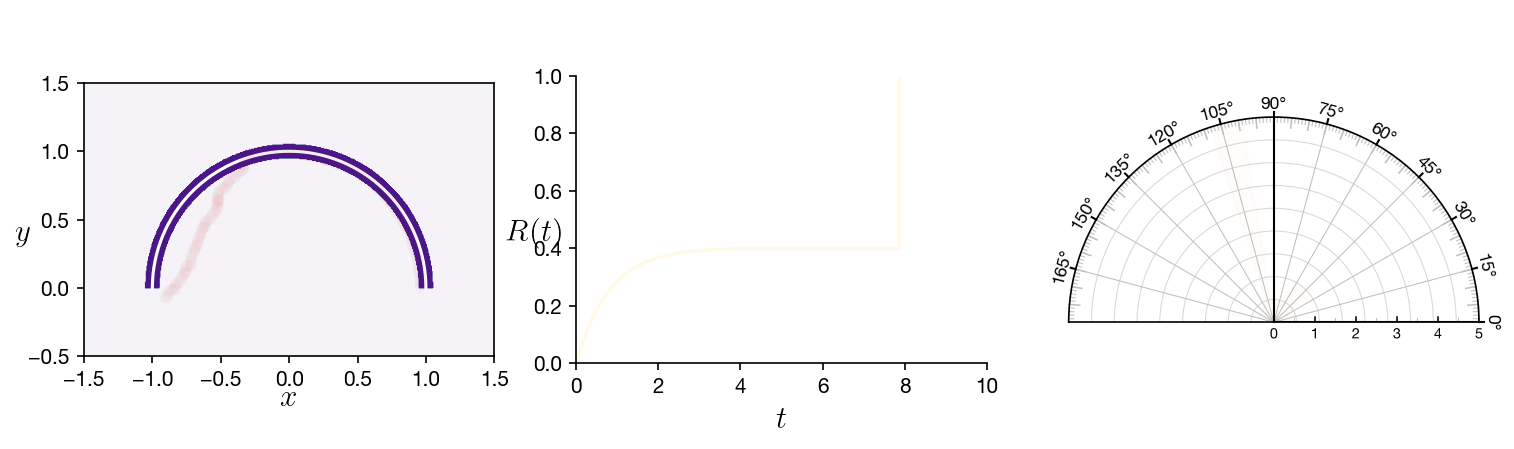

In [20]:
importlib.reload(pF)
fix, ax = pF.plotDef(5, p, xphm, yphm, phm)
pF.plotDat(fix, ax, p, rxFull, ryFull, phxFull, phyFull, rwdFull, ag.valFn)
plt.show()

Value function, $v(\phi)$ vs polar angle, $\phi$ at the last time-instant

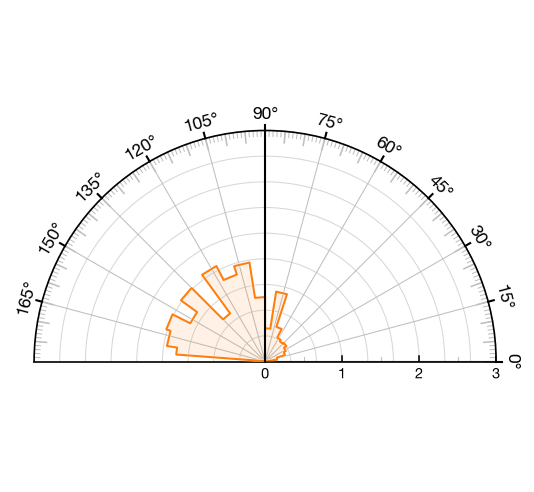

In [47]:
import importlib
importlib.reload(pF)
fig, ax = pF.plotRadial(3, p, ag.valFn)
plt.show()